In [1]:
import numpy as np

from qiskit import IBMQ, Aer, QuantumCircuit, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()

from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

In [13]:
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def diffuser(n):
    qc = QuantumCircuit(n,name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]), range(n))
    qc.h(range(n))
    return qc

def Grover(n, marked):
    qc = QuantumCircuit(n,n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n),range(n))
    qc.measure(range(n), range(n))
    return qc

In [14]:
n=5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n,marked)
qc.draw()

5 qubits, basis state [2] marked, 4 rounds


┌───┐┌─────────┐┌─────────────┐┌─────────┐┌─────────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0            ├┤0        ├┤0            ├┤0        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_1: ┤ H ├┤1        ├┤1            ├┤1        ├┤1            ├┤1        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_2: ┤ H ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├»
     ├───┤│         ││             ││         ││             ││         │»
q_3: ┤ H ├┤3        ├┤3            ├┤3        ├┤3            ├┤3        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_4: ┤ H ├┤4        ├┤4            ├┤4        ├┤4            ├┤4        ├»
     └───┘└─────────┘└─────────────┘└─────────┘└─────────────┘└─────────┘»
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«     ┌─────────────┐┌─────────┐┌─────────────┐┌─┐            
«q_0: ┤0            ├┤0        ├┤0            ├┤M├────────────
«     │             ││         ││             │└╥┘┌─┐         
«q_1: ┤1            ├┤1        ├┤1            ├─╫─┤M├─────────
«     │             ││         ││             │ ║ └╥┘┌─┐      
«q_2: ┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├─╫──╫─┤M├──────
«     │             ││         ││             │ ║  ║ └╥┘┌─┐   
«q_3: ┤3            ├┤3        ├┤3            ├─╫──╫──╫─┤M├───
«     │             ││         ││             │ ║  ║  ║ └╥┘┌─┐
«q_4: ┤4            ├┤4        ├┤4            ├─╫──╫──╫──╫─┤M├
«     └─────────────┘└─────────┘└─────────────┘ ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
«                                               0  1  2  3  4

{'00000': 1, '10100': 1, '10101': 1, '11000': 2, '00010': 9992, '00011': 1, '01000': 1, '01100': 1}
3.919534679768385


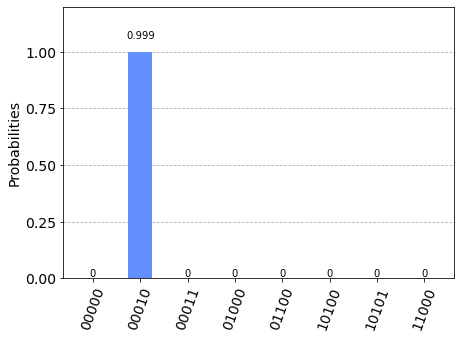

In [15]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots = 10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)

5 qubits, basis state [2] marked, 4 rounds


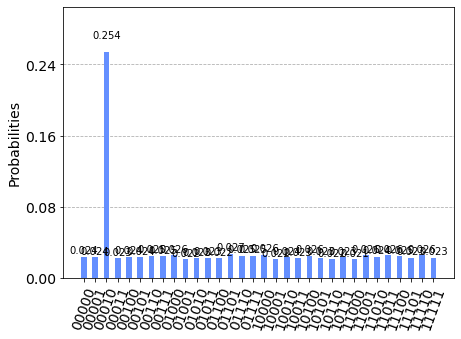

In [16]:
#choosing a lower r value
def Grover_run_roundwise(n, marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n,n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n, marked), range(n))
            qc.append(diffuser(n),range(n))
        qc.measure(range(n), range(n))
        result = execute(qc, backend, shots = 10000).result()
        counts.append(result.get_counts(qc))
    return counts

backend = Aer.get_backend('qasm_simulator')
counts = Grover_run_roundwise(n, marked)
plot_histogram(counts[0])

{'10000': 1, '10001': 1, '10011': 1, '10100': 1, '10101': 1, '11011': 2, '11101': 1, '11110': 1, '00010': 9983, '00011': 1, '00110': 1, '01001': 1, '01010': 1, '01011': 2, '01100': 1, '01111': 1}


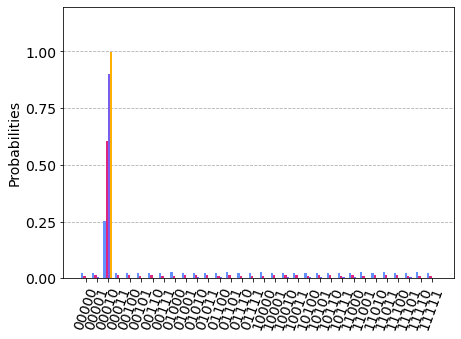

In [17]:
#predictions at different r values
print(counts[3])
plot_histogram(counts, bar_labels=False)